# LRPP Data Organizer
#### Jingzhi Kevin Yu
#### Date Updated: 11/13/21

## Environment Prep

In [3]:
# load packages
import pandas as pd
import numpy as np

In [4]:
# load data
df = pd.read_csv('/Volumes/fsmresfiles/PrevMed/Projects/MESA_RiskPred/LRPP data/LRPP.csv') # raw data 
target_df = pd.read_csv('/Volumes/fsmresfiles/PrevMed/Projects/MESA_RiskPred/Output/MESA_cleaned_DDH_ASCVDonly.csv') # target data

##### Sample Data

In [5]:
target_df.head()

,id,tte,label,cig,sbp,dbp,dm03,htnmed,hdl,chol,times,age,race,gender
0,0,17.0,0,1.0,147.5,80.0,0.0,0.0,59.0,169.0,1.0,51.0,1,1
1,0,17.0,0,1.0,132.0,80.0,0.0,NaN,64.0,218.0,3.0,53.0,1,1
2,0,17.0,0,1.0,129.5,78.5,0.0,0.0,55.0,196.0,5.0,55.0,1,1
3,0,17.0,0,1.0,137.0,81.0,1.0,0.0,64.0,201.0,7.0,57.0,1,1
4,0,17.0,0,1.0,143.5,80.5,1.0,1.0,59.0,205.0,10.0,60.0,1,1


## Data Wrangling

### Variable Selection and Renaming + Diabetes Variable Creation

In [6]:
# get relevant variables from main dataset
df = df.loc[:, ['AGE', 'ASCVD', 'RACE', 'SBP', 'DBP', 'RXHYP', 'TOTCHL', 'HDLCHL', 'ID_FINAL',
                'LENYASCVD', 'PREVALENT_CVD', 'SMOKER' ,'SEX', 'STUDY', 'LENYFL', 'EXAM', 'GLUCOSE', 'HXDIAB']]

# label diabetes
df['dm03'] = 0
df.loc[(df['GLUCOSE'] > 126) | (df['HXDIAB'] == 1), 'dm03'] = 1
df.loc[(df['GLUCOSE'].isna()) & (df['HXDIAB'].isna()), 'dm03'] = None

# change variable names
df = df.rename(columns = 
{
    'ID_FINAL':'id',
    'LENYASCVD':'tte', 
    'ASCVD':'label',
    'SMOKER':'cig', 
    'SBP':'sbp',
    'DBP':'dbp',
    'RXHYP':'htnmed',
    'HDLCHL':'hdl',
    'TOTCHL':'chol',
    'LENYFL':'times',
    'AGE':'age',
    'SEX':'gender',
    'RACE':'race'
})

# order data to match target data
df = df.loc[:, ['id', 'tte', 'label', 'cig', 'sbp', 'dbp', 'dm03', 'htnmed', 'hdl', 'chol', 'times', 'age', 'race', 'gender', 'EXAM', 'STUDY']]

In [7]:
print(df.groupby('STUDY').times.mean())
print(df.groupby('STUDY').times.max())
print(df.groupby('STUDY').times.min())

STUDY
1    18.525903
2    21.746108
3    10.579956
4    11.511635
5    22.516093
6    18.424410
7     5.954698
9    16.008429
Name: times, dtype: float64
STUDY
1    31.1
2    42.2
3    22.6
4    17.5
5    63.2
6    42.6
7    12.2
9    33.1
Name: times, dtype: float64
STUDY
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
9    0.0
Name: times, dtype: float64


In [8]:
print(df.groupby('STUDY').tte.mean())
print(df.groupby('STUDY').tte.max())
print(df.groupby('STUDY').tte.min())

STUDY
1    17.776247
2    21.311869
3     8.757602
4    11.041460
5    18.912107
6    16.601570
7     5.774156
9    15.185497
Name: tte, dtype: float64
STUDY
1    31.1
2    42.2
3    22.5
4    17.5
5    63.2
6    42.3
7    12.2
9    33.1
Name: tte, dtype: float64
STUDY
1   -23.6
2   -24.6
3    -9.5
4    -9.8
5   -47.0
6   -39.2
7   -10.3
9   -25.7
Name: tte, dtype: float64


### Data Cleaning
1. Update participant follow-up times and time to event
2. Remove records after censoring
3. Select and realign time of different studies
    1. FHS: Start from year 15
    2. FOF: Start from year 10
4. Remove particiapnts who have ASCVD from first 5 years

##### Update participant follow-up times and time to event(tte)

In [9]:
# get min date of each participant for follow-up times and time to event
times_max_list = df.groupby(['id']).times.max().reset_index()
times_max_list.columns = ['id', 'max_times']
tte_max_list = df.groupby(['id']).tte.max().reset_index()
tte_max_list.columns = ['id', 'max_tte']

# get times and tte variable 
df = pd.merge(df, times_max_list)
df = pd.merge(df, tte_max_list)

# times = max_times - follow-up time
df['times'] = df['max_times'] - df['times']
# tte = max tte
df['tte'] = df['max_tte'] 

# drop intermediate variables
df = df.drop(columns = ['max_times', 'max_tte'])

##### Select and realign study periods

In [10]:
# FHS start from year 15 
df.loc[(df['STUDY'] == 5), 'times'] = df.loc[(df['STUDY'] == 5), 'times'] - 15

# FOF start from year 10
df.loc[(df['STUDY'] == 6), 'times'] = df.loc[(df['STUDY'] == 6), 'times'] - 10

# CARDIA start from year 18
df.loc[(df['STUDY'] == 2), 'times'] = df.loc[(df['STUDY'] == 2), 'times'] - 18

# remove those with negative times
df = df.loc[df['times']>= 0]

##### Remove patients less than 40 and over 75

In [11]:
age_exclude = df.loc[(df['age'] <= 35) | (df['age'] >= 70), 'id'].drop_duplicates()

df = df.loc[~df['id'].isin(age_exclude)]

# number of unique participants
df.id.nunique()

25094

##### Remove records after censoring (CVD event)

In [12]:
# remove records after censoring
df = df.loc[df['tte'] >= df['times']]

# number of unique participants
df.id.nunique()

25063

##### Exclude participants that have ASCVD within the first 5 years

In [13]:
# Exclude participants with ASCVD within 5 years
df = df.loc[df['tte']> 5, :]

# number of unique participants
df.id.nunique()

23521

##### Create New IDs for Participants

In [14]:
# get id list of patients
pt_list = pd.DataFrame(df['id'].drop_duplicates())
pt_list['id_new'] = range(len(pt_list))
pt_list['id_new'] = pt_list['id_new'] + 1

df = pd.merge(df, pt_list)

df['id'] = df['id_new']
df = df.drop(columns = ['id_new'])

## Data Exploration

<AxesSubplot:>

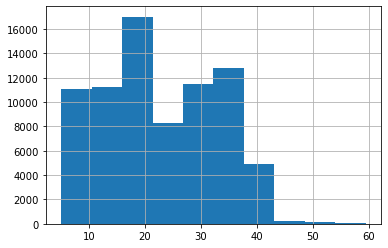

In [15]:
# TTE 
df['tte'].hist()

In [16]:
# smoking status
df['cig'].value_counts()

0.0    53394
1.0    18484
Name: cig, dtype: int64

In [17]:
# diabetes
df['dm03'].value_counts()

0.0    64933
1.0     9110
Name: dm03, dtype: int64

<AxesSubplot:>

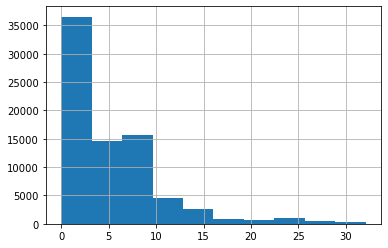

In [18]:
# times 
df['times'].hist()

<AxesSubplot:>

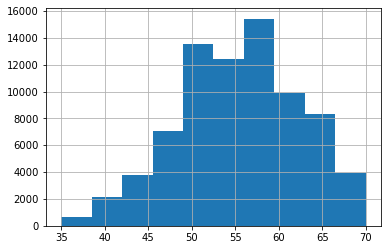

In [19]:
df['age'].hist()

In [20]:
df['race'].value_counts()

1    41250
2    22250
4    10480
3     3179
Name: race, dtype: int64

In [21]:
df['gender'].value_counts()

1    39495
2    37664
Name: gender, dtype: int64

## Missingness

In [22]:
# general missingness
round(df.isnull().sum() / len(df) * 100, 1)

id         0.0
tte        0.0
label      0.0
cig        6.8
sbp        0.6
dbp        0.6
dm03       4.0
htnmed     3.0
hdl       16.9
chol      10.6
times      0.0
age        0.0
race       0.0
gender     0.0
EXAM       0.0
STUDY      0.0
dtype: float64

In [23]:
# hdl missing
print(df.loc[df['hdl'].isna(), 'id'].nunique())
print(round(df.loc[df['hdl'].isna(), 'id'].nunique() / df['id'].nunique()*100,1), '%', sep = '')

5608
23.8%


In [24]:
# chol missing
print(df.loc[df['chol'].isna(), 'id'].nunique())
print(round(df.loc[df['chol'].isna(), 'id'].nunique() / df['id'].nunique()*100,1), '%', sep = '')

5183
22.0%


In [25]:
# smoking missing
print(df.loc[df['cig'].isna(), 'id'].nunique())
print(round(df.loc[df['cig'].isna(), 'id'].nunique() / df['id'].nunique()*100,1), '%', sep = '') 

3169
13.5%


In [26]:
df.loc[df['chol'].isna(), ['id', 'STUDY']].groupby(['STUDY']).id.nunique() / df.groupby(['STUDY']).id.nunique()

STUDY
1    0.029674
2    0.022108
3    0.761905
4    0.041866
5    0.673469
6    0.180943
7    0.309966
9    0.893824
Name: id, dtype: float64

### Filter Missing Data

In [27]:
# drop missing all longitudinal data
df = df[(~df['sbp'].isna()) & (~df['dbp'].isna()) & (~df['hdl'].isna()) & (~df['chol'].isna())]

# number of unique participants
df.id.nunique()

19845

## Output Data

#### Output final cleaned dataset

In [28]:
df.drop(columns = ['STUDY', 'EXAM']).to_csv('/Volumes/fsmresfiles/PrevMed/Projects/MESA_RiskPred/LRPP data/LRPP_final.csv', index = False)

#### Output raw cleaned dataset (with additional identifying variables)

In [29]:
df.to_csv('/Volumes/fsmresfiles/PrevMed/Projects/MESA_RiskPred/LRPP data/LRPP_raw.csv', index = False)

#### Output select dataset (ARIC, CARDIA, CHS, MESA, FHS, FOF)

In [33]:
df.loc[df['STUDY'].isin([1,2,3,4,5,6]), :].drop(columns = ['STUDY', 'EXAM']).to_csv('/Volumes/fsmresfiles/PrevMed/Projects/MESA_RiskPred/LRPP data/LRPP_select.csv', index = False)

#### Output Study Index

In [35]:
mesa_index = df.loc[:,['id', 'STUDY']].drop_duplicates()
mesa_index['study_index'] = False

# current selection: ARIC
mesa_index.loc[mesa_index['STUDY'] == 1, 'study_index'] = True

# output data
mesa_index.to_csv('/Volumes/fsmresfiles/PrevMed/Projects/MESA_RiskPred/LRPP data/mesa_index.csv', index = False)

#### Output Study SELECT Index

In [36]:
mesa_index_select = df.loc[df['STUDY'].isin([1,2,3,4,5,6]),['id', 'STUDY']].drop_duplicates()
mesa_index_select['study_index'] = False

# current selection: ARIC
mesa_index_select.loc[mesa_index_select['STUDY'] == 1, 'study_index'] = True

# output data
mesa_index_select.to_csv('/Volumes/fsmresfiles/PrevMed/Projects/MESA_RiskPred/LRPP data/mesa_index_select.csv', index = False)

### Number of final participants


In [ ]:
df.id.nunique()

## Evaluate Dataset

In [109]:
test = pd.read_csv('/Volumes/fsmresfiles/PrevMed/Projects/MESA_RiskPred/LRPP data/LRPP_select.csv')

In [110]:
test.head()

,id,tte,label,cig,sbp,dbp,dm03,htnmed,hdl,chol,times,age,race,gender
0,1,30.6,0,0.0,107.333333,69.333333,0.0,0.0,69.000,158.0,2.9,48.0,2,2
1,1,30.6,0,0.0,108.000000,73.333333,0.0,0.0,72.000,181.0,6.2,51.0,2,2
2,1,30.6,0,0.0,123.000000,80.000000,0.0,0.0,64.000,164.0,8.8,54.0,2,2
3,2,8.3,0,0.0,102.666667,68.666667,0.0,0.0,43.335,255.0,0.0,47.0,1,2
4,2,8.3,0,0.0,98.666667,58.666667,0.0,0.0,42.000,283.0,2.9,50.0,1,2


In [111]:
test.isna().sum()

id           0
tte          0
label        0
cig        288
sbp          0
dbp          0
dm03         4
htnmed    1092
hdl          0
chol         0
times        0
age          0
race         0
gender       0
dtype: int64

In [112]:
test.label.value_counts()

0    51579
1     6653
Name: label, dtype: int64

In [113]:
df.loc[df['STUDY'].isin([1,4,6]), :].label.value_counts()

0    40925
1     5327
Name: label, dtype: int64

In [114]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58232 entries, 0 to 58231
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      58232 non-null  int64  
 1   tte     58232 non-null  float64
 2   label   58232 non-null  int64  
 3   cig     57944 non-null  float64
 4   sbp     58232 non-null  float64
 5   dbp     58232 non-null  float64
 6   dm03    58228 non-null  float64
 7   htnmed  57140 non-null  float64
 8   hdl     58232 non-null  float64
 9   chol    58232 non-null  float64
 10  times   58232 non-null  float64
 11  age     58232 non-null  float64
 12  race    58232 non-null  int64  
 13  gender  58232 non-null  int64  
dtypes: float64(10), int64(4)
memory usage: 6.2 MB


In [115]:
test.head(20)

,id,tte,label,cig,sbp,dbp,dm03,htnmed,hdl,chol,times,age,race,gender
0,1,30.6,0,0.0,107.333333,69.333333,0.0,0.0,69.000,158.0,2.9,48.0,2,2
1,1,30.6,0,0.0,108.000000,73.333333,0.0,0.0,72.000,181.0,6.2,51.0,2,2
2,1,30.6,0,0.0,123.000000,80.000000,0.0,0.0,64.000,164.0,8.8,54.0,2,2
3,2,8.3,0,0.0,102.666667,68.666667,0.0,0.0,43.335,255.0,0.0,47.0,1,2
4,2,8.3,0,0.0,98.666667,58.666667,0.0,0.0,42.000,283.0,2.9,50.0,1,2
5,2,8.3,0,0.0,116.000000,70.666667,0.0,0.0,50.000,234.0,5.9,53.0,1,2
6,3,17.1,0,1.0,145.333333,98.000000,0.0,0.0,38.520,206.0,0.0,46.0,2,1
7,3,17.1,0,1.0,149.333333,93.333333,0.0,0.0,46.000,188.0,2.8,48.0,2,1
8,3,17.1,0,1.0,136.000000,94.000000,0.0,0.0,39.000,210.0,6.2,52.0,2,1
9,4,7.6,1,0.0,184.000000,101.333333,0.0,0.0,38.520,179.0,0.0,61.0,2,1
